In [1]:
import os
import sys
from typing import Union
from pathlib import Path

import numpy as np

from interpolate_river.functions import (
    remove_z_coordinate,
    split_line,
    interpolate_by_distance,
    points_from_line,
    compute_heads,
    prepare_table,
    heads_from_table,
    export_results, 
    plot_results
)
from utils import set_new_version
import geopandas as gpd

import matplotlib.pyplot as plt

# Step-by-step

### 1. Manual change of line -> snap line to points

### 2. interpolate line by distance -> 2 points shapefile

### 3. compute the heads for each point -> 1 point shapefile per date (columns = date, head, geometry)

#### Points -> Hc, Hb, Ha -> downstreamwards

$$ \frac{H_c - H_b}{H_c - (H_c - h)} = \frac{d_{cb}}{d} $$



### Run

In [2]:
# define directorties

root_dir = Path(os.getcwd()).parents[0]
raw = root_dir.joinpath('data/raw')
edit = root_dir.joinpath('data/edit')
output = root_dir.joinpath('data/output')

In [3]:
# step 1
sts_name = raw.joinpath('Neisse_WL_2017.shp')
sts_edit_name = edit.joinpath('edit_Neisse_WL_2017.shp')
stations = remove_z_coordinate(
    in_shp=sts_name,
    out_shp=sts_edit_name
)

In [4]:
# step 2 - split river line at each station

in_path = edit.joinpath('reference_line_river.shp')
in_gdf = gpd.read_file(in_path)
in_line = in_gdf.unary_union
mps = stations.unary_union
split_river, new_stations = split_line(in_line, mps)

for i, geo in enumerate(split_river.geoms):
    gdf = gpd.GeoDataFrame(geometry=[geo], crs=in_gdf.crs)
    out_path = set_new_version(in_path, versioning_suffix=f'_0{i}')
    gdf.to_file(out_path)

In [5]:
# reorder snapped stations and save them
snapped_geos = list(new_stations.geoms)
replace_geos = []
for i, geo in enumerate(stations.geometry):
    new_geo = [new_geo_i for new_geo_i in snapped_geos if new_geo_i.distance(geo) < 100][0]
    replace_geos.append(new_geo)
    
stations['geometry'] = replace_geos
out_path = set_new_version(sts_edit_name,  versioning_suffix=f'_0{2}') 
stations.to_file(out_path)

In [6]:
# step 3
# get points from each splitted line
splitted_lines = [
    line for line in os.listdir(edit)
    if line.startswith('reference_line_river_')
    if line.endswith('shp')
]
ref_out_path = edit.joinpath('interpolated_points_river.shp')
interpolated_points = []
for i, line_shp in enumerate(splitted_lines):
    split_distance = 5
    ref_path = edit.joinpath(line_shp)
    out_path = set_new_version(ref_out_path, versioning_suffix=f'_0{i}')
    interp_points = points_from_line(
        ref_path,
        out_path,
        split_distance
    )
    interpolated_points.append(interp_points)

D:\Repos\interpolate_river\.venv\lib\site-packages\geopandas\io\file.py:608: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


In [7]:
csv_path = raw.joinpath('River_WL_2017.csv')
pivot_df = prepare_table(csv_path)        # columns index are organizing from north to south

pair1 = ['Neisse_Hagenwerder', 'Neisse_NPS' ]
pair2 = ['Neisse_NPS', 'Neisse_Goerlitz']

pair1_gdf = stations.loc[
    stations.StationNam.isin(pair1)
]
pair2_gdf = stations.loc[
    stations.StationNam.isin(pair2)
]

interp_points2 = interpolated_points[0]
interp_points1 = interpolated_points[1]

In [8]:
results_pair1 = heads_from_table(pivot_df, pair1, interp_points1)
results_pair2 = heads_from_table(pivot_df, pair2, interp_points2)


save = True

heads_arr = export_results(
    output,
    results_pair1,
    results_pair2,
    drop_date_column=False,
    save=save
)

D:\Repos\Goerlitz_interpolation_problem\interpolate_river\functions.py:322: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


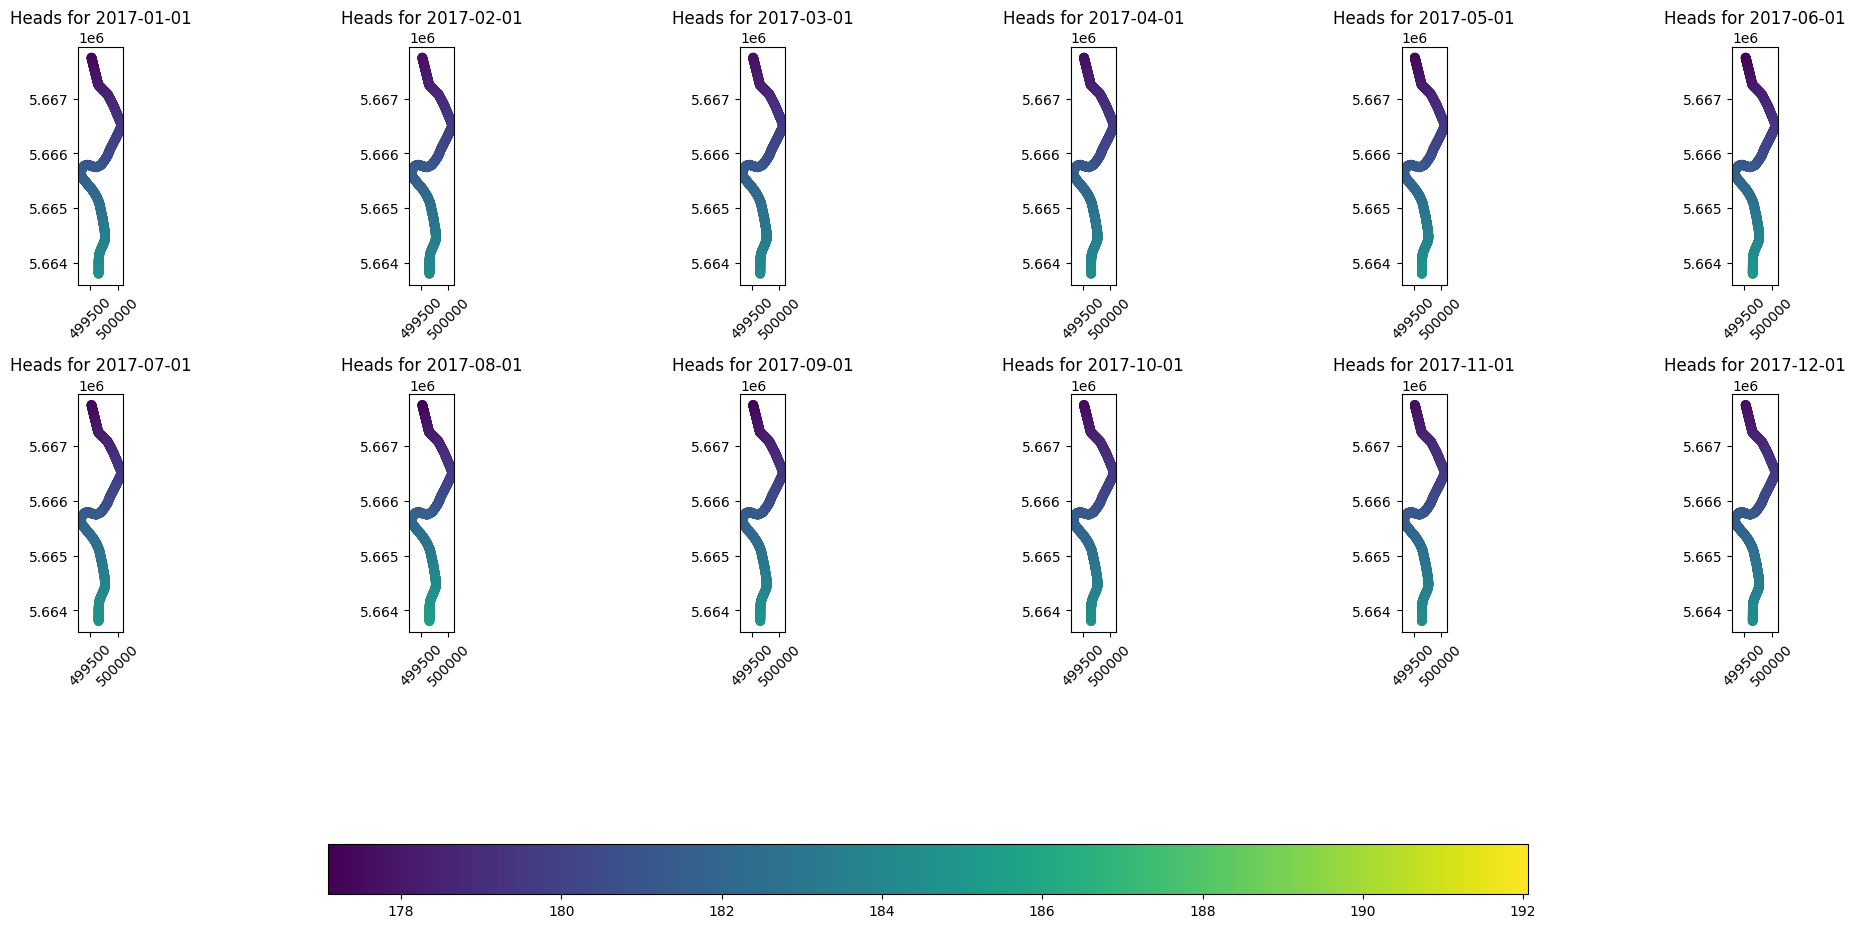

In [9]:
fig = plot_results(heads_arr)

In [10]:
fig.savefig(output.joinpath('heads_graph.png'), dpi=600)

## References

https://peps.python.org/pep-0008/